# Clustering for tevsimbad

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.neighbors import DistanceMetric
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import cluster
from sklearn.decomposition.pca import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
#path_to_gamma_bins shoud contain an absolute path to your gamma-bins directory
path_to_gamma_bins = os.path.dirname(os.getcwd()) + "/"

In [3]:
#name columns included in the final display
other_names = ['s_MAIN_ID', 's_class',  'tev_fermi_names', 'tev_classes', 'marked']
#from gamma bins directory
path_to_catalog = "markeddata/tevsimbad_TeVspectrum_normalized.txt"

In [4]:
spectra = pd.read_csv(path_to_gamma_bins +path_to_catalog)
spectra.head()

,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,s_FLUX_I,s_FLUX_G,s_FLUX_J,s_FLUX_H,s_FLUX_K,s_FLUX_u,...,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
0,0.0,0.000000,0.000000,0.000060,0.000000,0.000143,0.001702,0.003243,0.007779,0.0,...,0.484812,0.272675,0.056902,0.037315,0.135368,b'UCAC4 105-013663',Be,b'',b'other',0
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000338,0.019565,0.869940,0.0,...,0.045760,0.029010,0.025940,0.008455,0.000992,b'MSX6C G331.5487-00.5364',Be,b'',b'unid',0
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000009,0.002454,0.616424,0.0,...,0.148664,0.120621,0.081368,0.027734,0.002726,b'SSTGC 519103',Be,b'',b'unid',0
3,0.0,0.027707,0.045983,0.000000,0.000000,0.000000,0.132615,0.170842,0.205397,0.0,...,0.003439,0.230194,0.136930,0.045784,0.001110,b'RMC 141',B,b'',b'pwn',0
4,0.0,0.000531,0.000618,0.000343,0.000474,0.000618,0.000385,0.000260,0.000244,0.0,...,0.489456,0.275287,0.057447,0.037672,0.136665,b'[AAA97b] J053648.7-691700',B,b'',b'other',0


In [5]:
spectrum_columns = spectra.columns[:-len(other_names)]

In [6]:
def get_distance_metric(metric_function):
    if type(metric_function) == str:
        dist = DistanceMetric.get_metric(metric_function)
    else:
        dist = DistanceMetric.get_metric("pyfunc", func=metric_function)
    return dist

* ### earth mover's distance

In [7]:
# earth mover's distance
metric_function = st.wasserstein_distance
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
# spectra_distances = get_distance_metric(metric_function).pairwise(spectra[spectrum_columns])
#pd.DataFrame(spectra_distances).to_csv(path_to_gamma_bins +"markeddata/gevtev_spectra_EM_distances.txt", index=False)

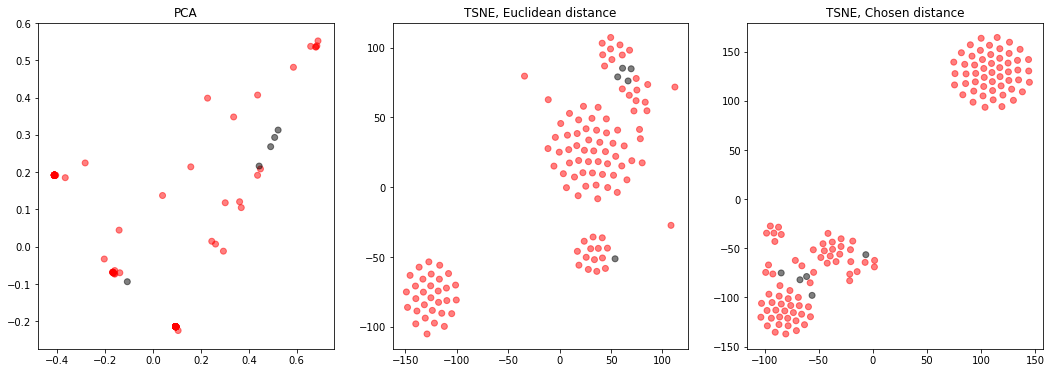

In [8]:
colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])

plt.subplots(figsize=(18, 6))
plt.subplot(131)
plt.title("PCA")
pca = PCA(n_components=2, random_state=42)
spectra_2D = pca.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(132)
plt.title("TSNE, Euclidean distance")
tsne = TSNE(n_components=2, random_state=42, learning_rate=500, n_iter=1500)
spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(133)
plt.title("TSNE, Chosen distance")
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=600)
spectra_2D = tsne.fit_transform(spectra_distances)
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
plt.show()

In [9]:
spectra_distances.min(), spectra_distances.max()

(0.0, 0.08012363671501417)

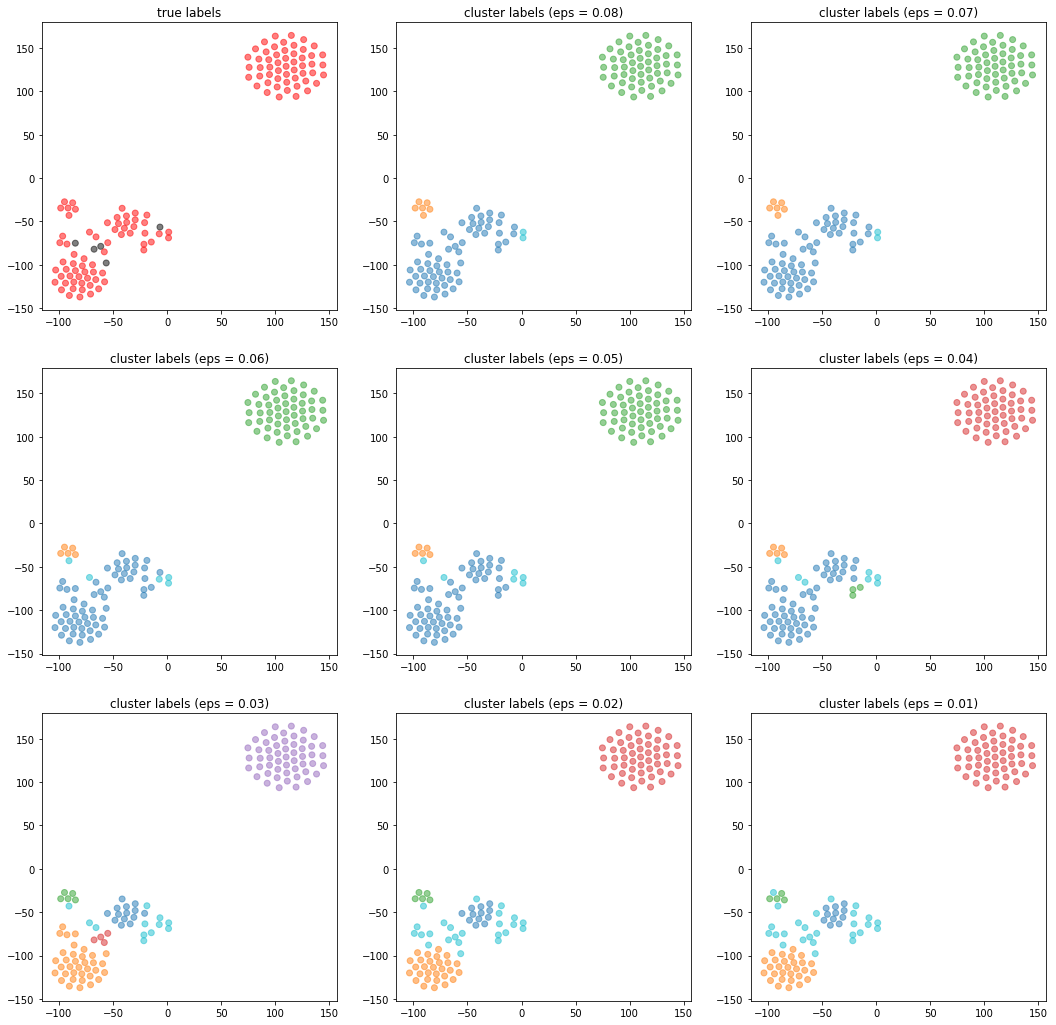

In [10]:
# visualization - tsne with Euclidean distance
# tsne = TSNE(n_components=2, random_state=42, learning_rate=1500)
# spectra_2D = tsne.fit_transform(spectra[spectrum_columns])

# visualization - tsne with chosen distance
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=600)
spectra_2D = tsne.fit_transform(spectra_distances)

plt.subplots(figsize=(18, 18))
plt.subplot(3, 3, 1)

colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])
plt.title("true labels")
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

eps_l = [0.01 * i for i in range(8, 0, -1)]
for i, eps in enumerate(eps_l):
    dbscan = cluster.DBSCAN(eps=eps, min_samples=4)
    cluster_labels = dbscan.fit_predict(spectra_distances)

    plt.subplot(3, 3, i + 2)
    c = [colors[l] for l in cluster_labels]
    plt.title("cluster labels (eps = {:.2})".format(eps))
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.show()

In [11]:
eps = 0.03

dbscan = cluster.DBSCAN(eps=eps, min_samples=2)
cluster_labels = dbscan.fit_predict(spectra_distances)
centers = []

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

col_name = 'DBSCAN_clusters_eps={}'.format(eps)
spectra[col_name] = cluster_labels
for i in set(cluster_labels):
    print("{} cluster ({})".format(i, colors[i]))
    display(spectra[spectra[col_name] == i][other_names])
    centers.append(spectra.loc[spectra[col_name] == i, spectrum_columns].mean(axis=0).values)
centers = pd.DataFrame(np.column_stack(centers).T, columns=spectrum_columns)

0 cluster (tab:blue)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
0,b'UCAC4 105-013663',Be,b'',b'other',0
4,b'[AAA97b] J053648.7-691700',B,b'',b'other',0
6,b'[ST92] 2-62B',B,b'',b'other',0
8,b'[ST92] 2-62',B,b'',b'other',0
9,b'HTR 13',B,b'',b'pwn',0
11,b'[M2002] LMC 164553',B,b'',b'other',0
13,b'[M2002] LMC 161594',B,b'',b'other',0
14,b'Cl* NGC 2070 SMB 283',B,b'',b'pwn',0
32,b'[LSB2000] Star 2',B0Ve,b'',b'other',0
34,b'UCAC2 1802729',B0Ve,b'',b'other',0


1 cluster (tab:orange)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
3,b'RMC 141',B,b'',b'pwn',0
16,b'CPD-69 416',B,b'',b'other',0


2 cluster (tab:green)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
5,b'OGLE LMC-ECL-20994',B,b'',b'pwn',0
15,b'SSTISAGE1C J053736.75-690633.4',B,b'',b'pwn',0
17,b'Cl* NGC 2070 SMB 455',O,b'',b'pwn',0
18,b'Cl* NGC 2070 SMB 206',O,b'',b'pwn',0
19,b'Cl* NGC 2070 SMB 163',O,b'',b'pwn',0
20,b'OGLE LMC-ECL-21453',O,b'',b'pwn',0
21,b'OGLE LMC-ECL-21400',O,b'',b'pwn',0
26,b'VFTS 318',O,b'',b'pwn',0
27,b'VFTS 183',B0Ve,b'',b'pwn',0
28,b'OGLE LMC-ECL-21065',B0Ve,b'',b'pwn',0


3 cluster (tab:red)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
10,b'LS IV -05 11',B,b'',b'unid',0
30,b'HD 43582',B0Ve,b'',b'snr',0


4 cluster (tab:purple)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
12,b'GCIRS 1W',B,b'',b'unid',0
22,b'[MCD2010] 18',O,b'',b'unid',0
24,b'[MCD2010] 13',O,b'',b'unid',0
25,b'[MCD2010] 13',O,b'',b'unid',0
110,b'[KRL2007b] 332',B0Ve,b'',b'unid',0


5 cluster (tab:brown)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
37,b'2MASS J05384705-6905016',B0Ve,b'',b'pwn',0
60,b'HD 259440',B0Ve,b'',b'bin',1
74,b'CPD-63 2495',B0Ve,b'',b'bin',1
93,b'SN 2004am',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


6 cluster (tab:pink)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
61,b'[CHP2004] J095549.8+693934',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
62,b'[MTK2001b] 8',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
63,b'[CHP2004] J095637.5+694137',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
64,b'CXOU J095601.7+694308',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
65,b'CXOU J095548.9+694010',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
66,b'CXOU J095527.1+693923',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
67,b'CXOU J095552.8+694020',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
68,b'CXOU J095552.4+694024',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
69,b'CXOU J095550.7+694039',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
70,b'CXOU J095547.5+694120',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


-1 cluster (tab:cyan)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
1,b'MSX6C G331.5487-00.5364',Be,b'',b'unid',0
2,b'SSTGC 519103',Be,b'',b'unid',0
7,b'[KKM2013] 7',B,b'',"b'pwn,snr'",0
23,b'GCIRS 8',O,b'',b'unid',0
49,b'RMC 142',B0Ve,b'',b'pwn',0
91,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856',b'bin',1
117,b'Brey 84',B0Ve,b'',b'pwn',0


* ### euclidean distance

In [12]:
# euclidean distance
from scipy.spatial.distance import euclidean
metric_function = "euclidean"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)

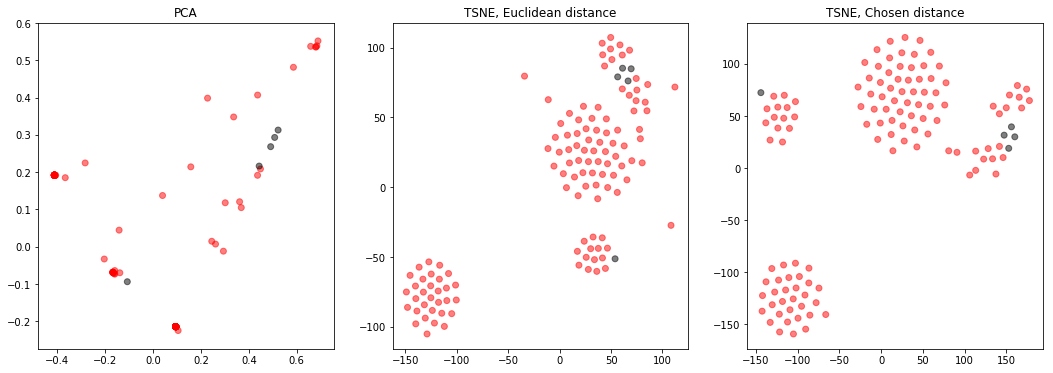

In [13]:
colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])

plt.subplots(figsize=(18, 6))
plt.subplot(131)
plt.title("PCA")
pca = PCA(n_components=2, random_state=42)
spectra_2D = pca.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(132)
plt.title("TSNE, Euclidean distance")
tsne = TSNE(n_components=2, random_state=42, learning_rate=500, n_iter=1500)
spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(133)
plt.title("TSNE, Chosen distance")
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=500)
spectra_2D = tsne.fit_transform(spectra_distances)
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
plt.show()

In [14]:
spectra_distances.min(), spectra_distances.max()

(0.0, 1.1842928259153624)

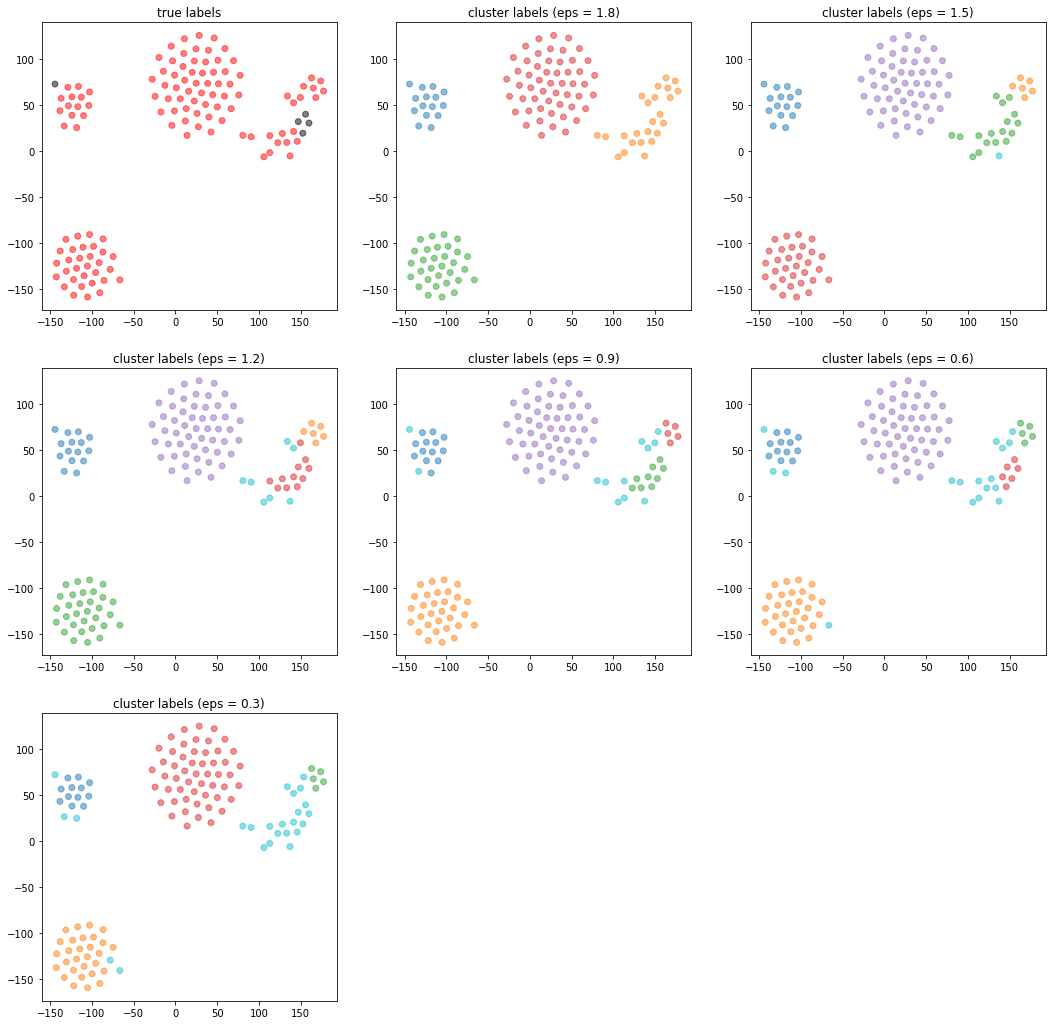

In [15]:
# visualization - tsne with Euclidean distance
# tsne = TSNE(n_components=2, random_state=42, learning_rate=1500)
# spectra_2D = tsne.fit_transform(spectra[spectrum_columns])

# visualization - tsne with chosen distance
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=500)
spectra_2D = tsne.fit_transform(spectra_distances)

plt.subplots(figsize=(18, 18))
plt.subplot(3, 3, 1)

colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])
plt.title("true labels")
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

eps_l = [0.1 * i for i in range(18, 0, -3)]
for i, eps in enumerate(eps_l):
    dbscan = cluster.DBSCAN(eps=eps, min_samples=4)
    cluster_labels = dbscan.fit_predict(spectra_distances)

    plt.subplot(3, 3, i + 2)
    c = [colors[l] for l in cluster_labels]
    plt.title("cluster labels (eps = {:.2})".format(eps))
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.show()

In [16]:
eps = 1.2

dbscan = cluster.DBSCAN(eps=eps, min_samples=2)
cluster_labels = dbscan.fit_predict(spectra_distances)
centers = []

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

col_name = 'DBSCAN_clusters_eps={}'.format(eps)
spectra[col_name] = cluster_labels
for i in set(cluster_labels):
    print("{} cluster ({})".format(i, colors[i]))
    display(spectra[spectra[col_name] == i][other_names])
    centers.append(spectra.loc[spectra[col_name] == i, spectrum_columns].mean(axis=0).values)
centers = pd.DataFrame(np.column_stack(centers).T, columns=spectrum_columns)

0 cluster (tab:blue)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
0,b'UCAC4 105-013663',Be,b'',b'other',0
4,b'[AAA97b] J053648.7-691700',B,b'',b'other',0
6,b'[ST92] 2-62B',B,b'',b'other',0
7,b'[KKM2013] 7',B,b'',"b'pwn,snr'",0
8,b'[ST92] 2-62',B,b'',b'other',0
11,b'[M2002] LMC 164553',B,b'',b'other',0
13,b'[M2002] LMC 161594',B,b'',b'other',0
32,b'[LSB2000] Star 2',B0Ve,b'',b'other',0
34,b'UCAC2 1802729',B0Ve,b'',b'other',0
35,b'[ST92] 2-27',B0Ve,b'',b'other',0


1 cluster (tab:orange)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
1,b'MSX6C G331.5487-00.5364',Be,b'',b'unid',0
12,b'GCIRS 1W',B,b'',b'unid',0
22,b'[MCD2010] 18',O,b'',b'unid',0
24,b'[MCD2010] 13',O,b'',b'unid',0
25,b'[MCD2010] 13',O,b'',b'unid',0
110,b'[KRL2007b] 332',B0Ve,b'',b'unid',0


2 cluster (tab:green)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
2,b'SSTGC 519103',Be,b'',b'unid',0
3,b'RMC 141',B,b'',b'pwn',0
10,b'LS IV -05 11',B,b'',b'unid',0
16,b'CPD-69 416',B,b'',b'other',0
23,b'GCIRS 8',O,b'',b'unid',0
30,b'HD 43582',B0Ve,b'',b'snr',0
36,b'[MT91] 213',B0Ve,b'',b'unid',0
37,b'2MASS J05384705-6905016',B0Ve,b'',b'pwn',0
48,b'Schulte 21',B0Ve,b'',b'unid',0
49,b'RMC 142',B0Ve,b'',b'pwn',0


3 cluster (tab:red)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
5,b'OGLE LMC-ECL-20994',B,b'',b'pwn',0
14,b'Cl* NGC 2070 SMB 283',B,b'',b'pwn',0
15,b'SSTISAGE1C J053736.75-690633.4',B,b'',b'pwn',0
17,b'Cl* NGC 2070 SMB 455',O,b'',b'pwn',0
18,b'Cl* NGC 2070 SMB 206',O,b'',b'pwn',0
19,b'Cl* NGC 2070 SMB 163',O,b'',b'pwn',0
20,b'OGLE LMC-ECL-21453',O,b'',b'pwn',0
21,b'OGLE LMC-ECL-21400',O,b'',b'pwn',0
26,b'VFTS 318',O,b'',b'pwn',0
27,b'VFTS 183',B0Ve,b'',b'pwn',0


4 cluster (tab:purple)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
61,b'[CHP2004] J095549.8+693934',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
62,b'[MTK2001b] 8',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
63,b'[CHP2004] J095637.5+694137',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
64,b'CXOU J095601.7+694308',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
65,b'CXOU J095548.9+694010',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
66,b'CXOU J095527.1+693923',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
67,b'CXOU J095552.8+694020',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
68,b'CXOU J095552.4+694024',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
69,b'CXOU J095550.7+694039',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
70,b'CXOU J095547.5+694120',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


-1 cluster (tab:cyan)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
9,b'HTR 13',B,b'',b'pwn',0
93,b'SN 2004am',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
108,b'CXOM82 J095538.3+694030',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


* ### cosine distance

In [17]:
# cosine distance
# from scipy.spatial.distance import cosine
metric_function = "cosine"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)

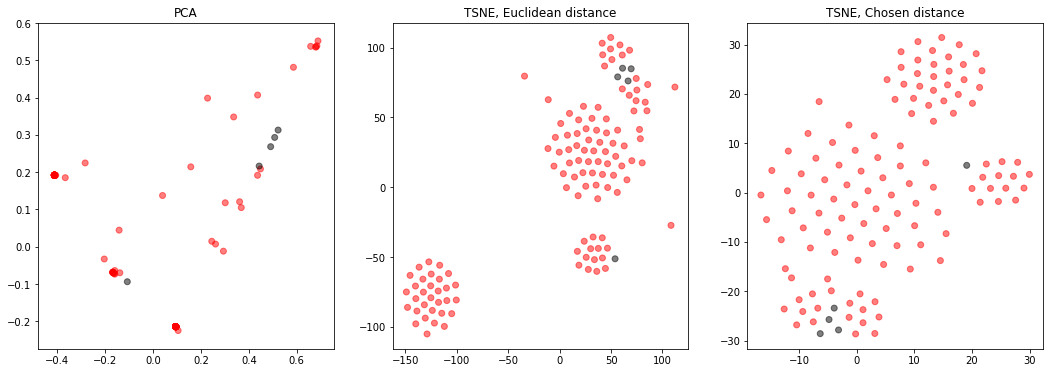

In [18]:
colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])

plt.subplots(figsize=(18, 6))
plt.subplot(131)
plt.title("PCA")
pca = PCA(n_components=2, random_state=42)
spectra_2D = pca.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(132)
plt.title("TSNE, Euclidean distance")
tsne = TSNE(n_components=2, random_state=42, learning_rate=500, n_iter=1500)
spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(133)
plt.title("TSNE, Chosen distance")
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=400)
spectra_2D = tsne.fit_transform(spectra_distances)
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
plt.show()

In [19]:
spectra_distances.min(), spectra_distances.max()

(0.0, 1.0)

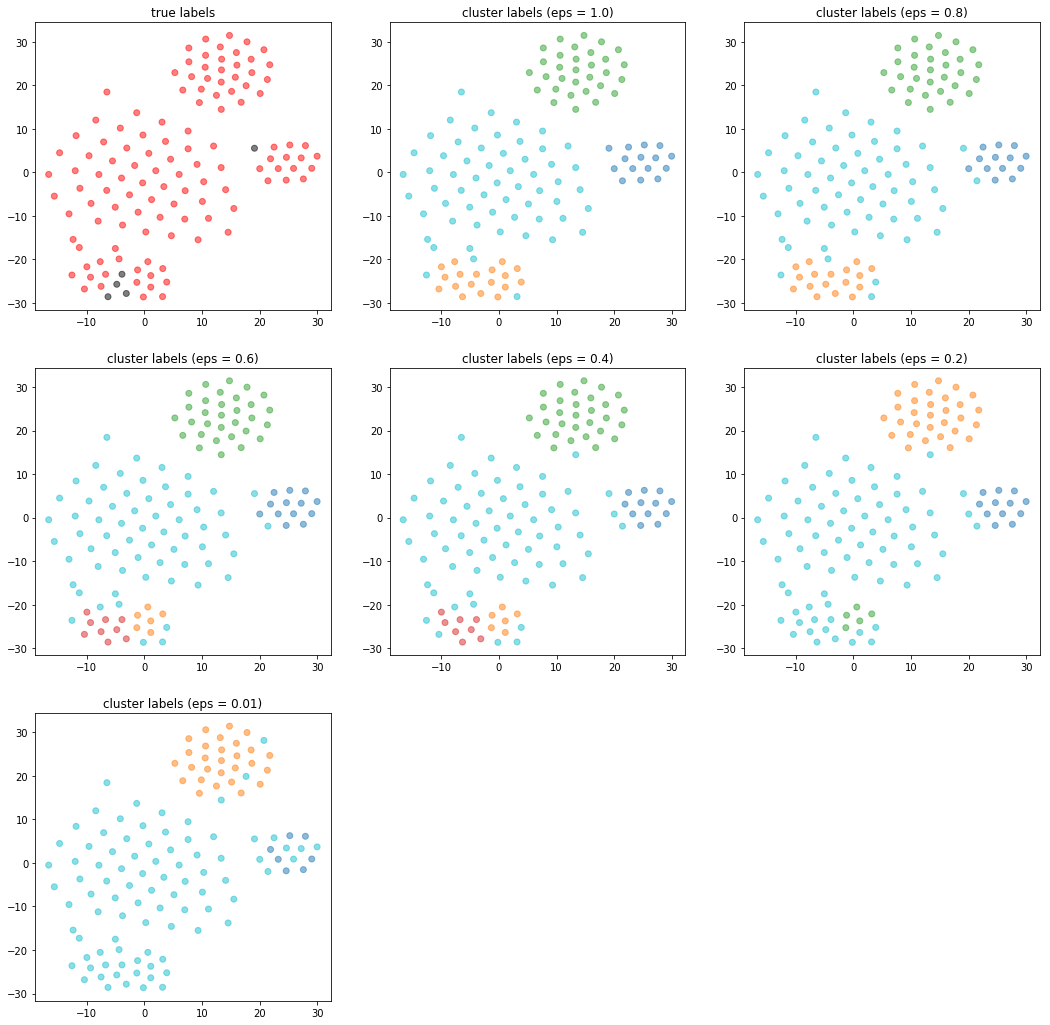

In [20]:
# visualization - tsne with Euclidean distance
# tsne = TSNE(n_components=2, random_state=42, learning_rate=1500)
# spectra_2D = tsne.fit_transform(spectra[spectrum_columns])

# visualization - tsne with chosen distance
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=400)
spectra_2D = tsne.fit_transform(spectra_distances)

plt.subplots(figsize=(18, 18))
plt.subplot(3, 3, 1)

colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])
plt.title("true labels")
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

eps_l = [0.1 * i for i in range(10, 0, -2)] + [0.01]
for i, eps in enumerate(eps_l):
    dbscan = cluster.DBSCAN(eps=eps, min_samples=4)
    cluster_labels = dbscan.fit_predict(spectra_distances)

    plt.subplot(3, 3, i + 2)
    c = [colors[l] for l in cluster_labels]
    plt.title("cluster labels (eps = {:.2})".format(eps))
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.show()

In [21]:
eps = 0.6

dbscan = cluster.DBSCAN(eps=eps, min_samples=2)
cluster_labels = dbscan.fit_predict(spectra_distances)
centers = []

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

col_name = 'DBSCAN_clusters_eps={}'.format(eps)
spectra[col_name] = cluster_labels
for i in set(cluster_labels):
    print("{} cluster ({})".format(i, colors[i]))
    display(spectra[spectra[col_name] == i][other_names])
    centers.append(spectra.loc[spectra[col_name] == i, spectrum_columns].mean(axis=0).values)
centers = pd.DataFrame(np.column_stack(centers).T, columns=spectrum_columns)

0 cluster (tab:blue)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
0,b'UCAC4 105-013663',Be,b'',b'other',0
4,b'[AAA97b] J053648.7-691700',B,b'',b'other',0
6,b'[ST92] 2-62B',B,b'',b'other',0
8,b'[ST92] 2-62',B,b'',b'other',0
11,b'[M2002] LMC 164553',B,b'',b'other',0
13,b'[M2002] LMC 161594',B,b'',b'other',0
32,b'[LSB2000] Star 2',B0Ve,b'',b'other',0
34,b'UCAC2 1802729',B0Ve,b'',b'other',0
35,b'[ST92] 2-27',B0Ve,b'',b'other',0
38,b'[ST92] 2-8',B0Ve,b'',b'other',0


1 cluster (tab:orange)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
1,b'MSX6C G331.5487-00.5364',Be,b'',b'unid',0
12,b'GCIRS 1W',B,b'',b'unid',0
22,b'[MCD2010] 18',O,b'',b'unid',0
24,b'[MCD2010] 13',O,b'',b'unid',0
25,b'[MCD2010] 13',O,b'',b'unid',0
110,b'[KRL2007b] 332',B0Ve,b'',b'unid',0


2 cluster (tab:green)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
5,b'OGLE LMC-ECL-20994',B,b'',b'pwn',0
14,b'Cl* NGC 2070 SMB 283',B,b'',b'pwn',0
15,b'SSTISAGE1C J053736.75-690633.4',B,b'',b'pwn',0
17,b'Cl* NGC 2070 SMB 455',O,b'',b'pwn',0
18,b'Cl* NGC 2070 SMB 206',O,b'',b'pwn',0
19,b'Cl* NGC 2070 SMB 163',O,b'',b'pwn',0
20,b'OGLE LMC-ECL-21453',O,b'',b'pwn',0
21,b'OGLE LMC-ECL-21400',O,b'',b'pwn',0
26,b'VFTS 318',O,b'',b'pwn',0
27,b'VFTS 183',B0Ve,b'',b'pwn',0


3 cluster (tab:red)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
10,b'LS IV -05 11',B,b'',b'unid',0
30,b'HD 43582',B0Ve,b'',b'snr',0
36,b'[MT91] 213',B0Ve,b'',b'unid',0
48,b'Schulte 21',B0Ve,b'',b'unid',0
49,b'RMC 142',B0Ve,b'',b'pwn',0
59,b'LS I +61 303',B0Ve,b'',b'bin',1
60,b'HD 259440',B0Ve,b'',b'bin',1
74,b'CPD-63 2495',B0Ve,b'',b'bin',1
114,b'V* V479 Sct',B0Ve,b'',b'bin',1


-1 cluster (tab:cyan)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
2,b'SSTGC 519103',Be,b'',b'unid',0
3,b'RMC 141',B,b'',b'pwn',0
7,b'[KKM2013] 7',B,b'',"b'pwn,snr'",0
9,b'HTR 13',B,b'',b'pwn',0
16,b'CPD-69 416',B,b'',b'other',0
23,b'GCIRS 8',O,b'',b'unid',0
37,b'2MASS J05384705-6905016',B0Ve,b'',b'pwn',0
61,b'[CHP2004] J095549.8+693934',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
62,b'[MTK2001b] 8',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
63,b'[CHP2004] J095637.5+694137',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


* ### energy distance

In [22]:
# energy distance
metric_function = st.energy_distance
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)

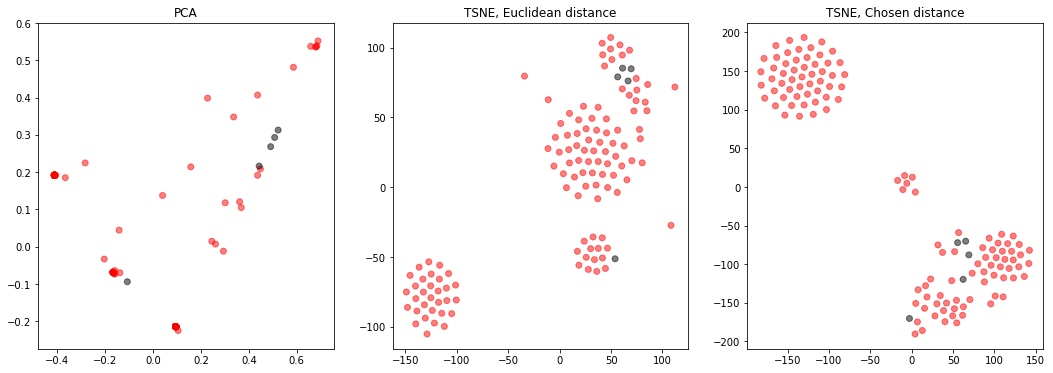

In [23]:
colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])

plt.subplots(figsize=(18, 6))
plt.subplot(131)
plt.title("PCA")
pca = PCA(n_components=2, random_state=42)
spectra_2D = pca.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(132)
plt.title("TSNE, Euclidean distance")
tsne = TSNE(n_components=2, random_state=42, learning_rate=500, n_iter=1500)
spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.subplot(133)
plt.title("TSNE, Chosen distance")
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=750)
spectra_2D = tsne.fit_transform(spectra_distances)
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
plt.show()

In [24]:
spectra_distances.min(), spectra_distances.max()

(0.0, 0.17841271269111608)

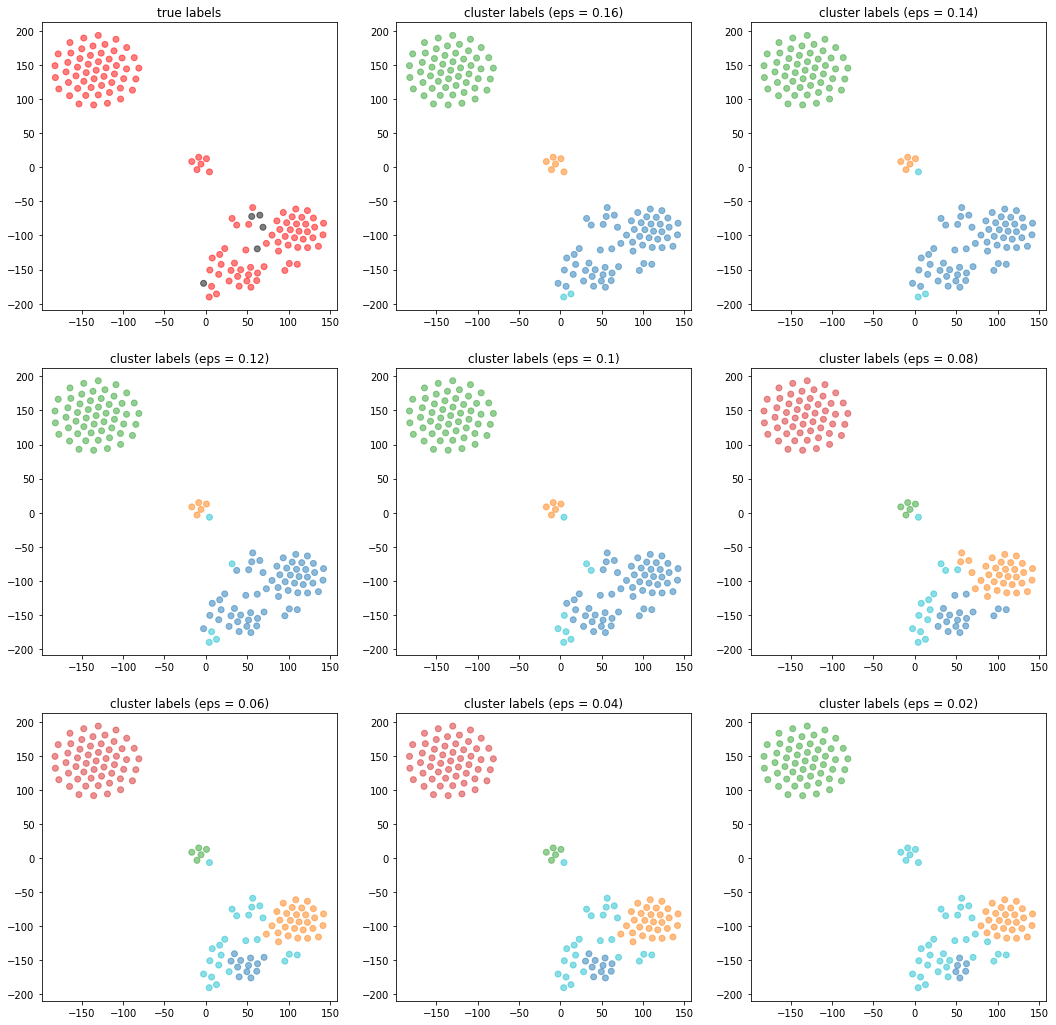

In [27]:
# visualization - tsne with Euclidean distance
# tsne = TSNE(n_components=2, random_state=42, learning_rate=1500)
# spectra_2D = tsne.fit_transform(spectra[spectrum_columns])

# visualization - tsne with chosen distance
tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=750)
spectra_2D = tsne.fit_transform(spectra_distances)

plt.subplots(figsize=(18, 18))
plt.subplot(3, 3, 1)

colors = ['red','black']
c = spectra['marked'].apply(lambda x: colors[x])
plt.title("true labels")
plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

eps_l = [0.01 * i for i in range(16, 0, -2)]
for i, eps in enumerate(eps_l):
    dbscan = cluster.DBSCAN(eps=eps, min_samples=4)
    cluster_labels = dbscan.fit_predict(spectra_distances)

    plt.subplot(3, 3, i + 2)
    c = [colors[l] for l in cluster_labels]
    plt.title("cluster labels (eps = {:.2})".format(eps))
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

plt.show()

In [28]:
eps = 0.08

dbscan = cluster.DBSCAN(eps=eps, min_samples=2)
cluster_labels = dbscan.fit_predict(spectra_distances)
centers = []

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

col_name = 'DBSCAN_clusters_eps={}'.format(eps)
spectra[col_name] = cluster_labels
for i in set(cluster_labels):
    print("{} cluster ({})".format(i, colors[i]))
    display(spectra[spectra[col_name] == i][other_names])
    centers.append(spectra.loc[spectra[col_name] == i, spectrum_columns].mean(axis=0).values)
centers = pd.DataFrame(np.column_stack(centers).T, columns=spectrum_columns)

0 cluster (tab:blue)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
0,b'UCAC4 105-013663',Be,b'',b'other',0
4,b'[AAA97b] J053648.7-691700',B,b'',b'other',0
6,b'[ST92] 2-62B',B,b'',b'other',0
8,b'[ST92] 2-62',B,b'',b'other',0
11,b'[M2002] LMC 164553',B,b'',b'other',0
13,b'[M2002] LMC 161594',B,b'',b'other',0
14,b'Cl* NGC 2070 SMB 283',B,b'',b'pwn',0
32,b'[LSB2000] Star 2',B0Ve,b'',b'other',0
34,b'UCAC2 1802729',B0Ve,b'',b'other',0
35,b'[ST92] 2-27',B0Ve,b'',b'other',0


1 cluster (tab:orange)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
5,b'OGLE LMC-ECL-20994',B,b'',b'pwn',0
15,b'SSTISAGE1C J053736.75-690633.4',B,b'',b'pwn',0
17,b'Cl* NGC 2070 SMB 455',O,b'',b'pwn',0
18,b'Cl* NGC 2070 SMB 206',O,b'',b'pwn',0
19,b'Cl* NGC 2070 SMB 163',O,b'',b'pwn',0
20,b'OGLE LMC-ECL-21453',O,b'',b'pwn',0
21,b'OGLE LMC-ECL-21400',O,b'',b'pwn',0
26,b'VFTS 318',O,b'',b'pwn',0
27,b'VFTS 183',B0Ve,b'',b'pwn',0
28,b'OGLE LMC-ECL-21065',B0Ve,b'',b'pwn',0


2 cluster (tab:green)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
7,b'[KKM2013] 7',B,b'',"b'pwn,snr'",0
10,b'LS IV -05 11',B,b'',b'unid',0
30,b'HD 43582',B0Ve,b'',b'snr',0


3 cluster (tab:red)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
12,b'GCIRS 1W',B,b'',b'unid',0
22,b'[MCD2010] 18',O,b'',b'unid',0
24,b'[MCD2010] 13',O,b'',b'unid',0
25,b'[MCD2010] 13',O,b'',b'unid',0
110,b'[KRL2007b] 332',B0Ve,b'',b'unid',0


4 cluster (tab:purple)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
61,b'[CHP2004] J095549.8+693934',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
62,b'[MTK2001b] 8',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
63,b'[CHP2004] J095637.5+694137',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
64,b'CXOU J095601.7+694308',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
65,b'CXOU J095548.9+694010',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
66,b'CXOU J095527.1+693923',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
67,b'CXOU J095552.8+694020',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
68,b'CXOU J095552.4+694024',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
69,b'CXOU J095550.7+694039',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
70,b'CXOU J095547.5+694120',B0Ve,"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


-1 cluster (tab:cyan)


,s_MAIN_ID,s_class,tev_fermi_names,tev_classes,marked
1,b'MSX6C G331.5487-00.5364',Be,b'',b'unid',0
2,b'SSTGC 519103',Be,b'',b'unid',0
3,b'RMC 141',B,b'',b'pwn',0
9,b'HTR 13',B,b'',b'pwn',0
16,b'CPD-69 416',B,b'',b'other',0
23,b'GCIRS 8',O,b'',b'unid',0
37,b'2MASS J05384705-6905016',B0Ve,b'',b'pwn',0
43,b'[M2002] LMC 164299',B0Ve,b'',b'other',0
49,b'RMC 142',B0Ve,b'',b'pwn',0
91,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856',b'bin',1
